<a href="https://colab.research.google.com/github/ece324-2019/AER202/blob/master/aer202_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torchvision
from torchvision import datasets,transforms,models
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import *
from torchsummary import summary
import time
import json
import copy
import os
import argparse
from PIL import Image
from collections import OrderedDict


from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#from utils import process_images

In [2]:

# DECLARE DIRECTORIES
# train_dir = 'datasets/test_cropped'
# FULL_IMAGE_DIR = 'datasets/full'

# Google Colab - pull dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
FULL_IMAGE_DIR = '/content/drive/My Drive/AER202/final_dataset_square'

In [12]:
# Args
def parse_arguments():
    parser = argparse.ArgumentParser(
        prog='AER202', description='Tool that uses machine learning to identify planes from a photo.')
    parser.add_argument('--batch_size', '-b', type=int, default=64,
                        help='Size of batches to use during training')
    parser.add_argument('--learning_rate', '-lr', type=float,
                        default=0.01, help='Learning rate to use during training')
    parser.add_argument('--epochs', '-e', type=int, default=25,
                        help='Number of epochs to use during training')
    parser.add_argument('--eval_every', '-ee', type=int, default=10,
                        help='Number of epochs to wait before evaluating accuracy of model')
    parser.add_argument('--seed', '-s', type=int, default=1,
                        help='Seed to use for any random functions')
    parser.add_argument('--disable_cuda', '-dcuda',
                        action='store_true', help='Disable CUDA')
    parser.add_argument('--process_images', '-pi', action='store_true',
                        help='Prepare images for training by performing actions such as cropping and downscaling')
    parser.add_argument('--small_dataset', '-sd', action='store_true',
                        help='Train and validate on a smaller test dataset for quick testing')
    
    # For local running
    # args = parser.parse_args()

    # For Google Colab
    args = parser.parse_args(args=[])

    return args


# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')


## Display Image for Tensor
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax


# Get class (label) names
def get_classes(is_small_dataset: bool):
    """Get names of classes from the immediate subdirectories of the main image directory"""
    images_dir = TEST_IMAGE_DIR if is_small_dataset else FULL_IMAGE_DIR
    classes = next(os.walk(images_dir))[1]

    return classes


# One Hot Encode
def one_hot(x, dim):
    vec = torch.zeros(dim)
    vec[x] = 1.0
    return vec


# # Evaluate Function 
# def evaluate(model, val_loader, cuda_enabled):
#     total_corr = 0

#     for i, batch in enumerate(val_loader):
#         features, label = batch
#         if cuda_enabled:
#             features = features.cuda()
#             label = label.cuda()

#         # Run model on data
#         prediction = model(features)

#         # Check number of correct predictions
#         torch_max = torch.max(prediction, 1)
#         for j in range(prediction.size()[0]):
#             if torch_max[1][j].item() == label[j].item():
#                 total_corr += 1

#     return float(total_corr) / len(val_loader.dataset)


# Create Custom Classifier
def build_classifier(num_in_features, hidden_layers, num_out_features):
    classifier = nn.Sequential()

    # NO HIDDEN LAYERS
    if hidden_layers == None:
        classifier.add_module('fc0', nn.Linear(num_in_features, num_out_features))

    # HAVE HIDDEN LAYERS
    else:
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        # Fully connected layers to be optimized
        classifier.add_module('fc0', nn.Linear(num_in_features, hidden_layers[0]))
        classifier.add_module('relu0', nn.ReLU())
        # Dropout to reduce overfitting
        classifier.add_module('drop0', nn.Dropout(.6))

        for i, (h1, h2) in enumerate(layer_sizes):
            classifier.add_module('fc' + str(i + 1), nn.Linear(h1, h2))
            classifier.add_module('relu' + str(i + 1), nn.ReLU())
            classifier.add_module('drop' + str(i + 1), nn.Dropout(.5))
        classifier.add_module('output', nn.Linear(hidden_layers[-1], num_out_features))

    return classifier


# Training Loop
def train_model(model, criterion, optimizer, sched, num_epochs=5, device='cuda'):
    start = time.time()
    train_results = []
    valid_results = []
    test_results = []

    # Saving best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        
        # Each epoch has a training/val/test phase
        for phase in ['train', 'valid', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode 

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
              inputs = inputs.to(device)
              labels = labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward pass
              with torch.set_grad_enabled(phase == 'train'):
                  # make prediction
                  outputs = model(inputs)
                  _, preds = torch.max(outputs, 1)
                  loss = criterion(outputs, labels)

                  # backward + optimize only if in training phase
                  if phase == 'train':
                      # sched.step()
                      loss.backward()
                      # update parameters
                      optimizer.step()

              # update statistics
              running_loss += loss.item() * inputs.size(0)
              #print('Predictions & Labels:')
              #print(preds)
              #print(labels.data)
              running_corrects += torch.sum(preds == labels.data)

            # Normalize loss for this epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # TRAINING PHASE
            if (phase == 'train'):
                train_results.append([epoch_loss, epoch_acc])

            # VALIDATION PHASE
            if (phase == 'valid'):
                valid_results.append([epoch_loss, epoch_acc])

            # TEST PHASE
            if (phase == 'test'):
                test_results.append([epoch_loss, epoch_acc])

            # DISPLAY STATISTICS
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model (Early Stopping) and save when we get best accuracy
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                
                # Copy out the best model
                best_model_wts = copy.deepcopy(model.state_dict())

                # Save on drive (!)
                model_save_name = "aer202_resnet_model.pt"
                path = F"/content/drive/My Drive/{model_save_name}"
                torch.save(model.state_dict(), path)
                
        print()

    # Calculating time it took for model to train
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, train_results, valid_results, test_results

CUDA is available!  Training on GPU ...


Total Number of Images:  3600
Number of Images in Train:  2304
Number of Images in Valid:  720
Number of Images in Test:  576
Number of Aircraft Types:  12
Classes: ['Air Canada Airbus A319', 'Air Canada Airbus A320', 'Air Canada Airbus A321', 'Air Canada Airbus A330-300', 'Air Canada Boeing 767-300', 'Air Canada Rouge Boeing 767-300', 'Air Transat Airbus A330-300', 'Airbus Beluga', 'American Boeing 777-300ER', 'Lufthansa Boeing 747-400', 'Porter Bombardier Q400', 'Westjet Boeing 737-800']
Air Transat Airbus A330-300
Air Canada Rouge Boeing 767-300
Air Canada Airbus A319
Air Canada Airbus A321
Airbus Beluga


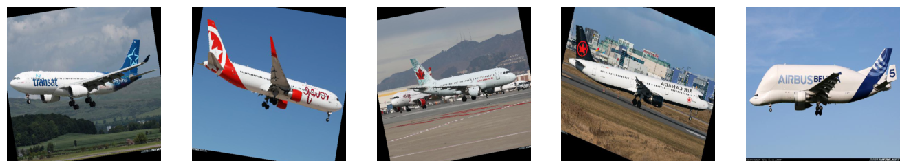

In [11]:
# def main():

# Parse args
args = parse_arguments()
# Set random seed
torch.manual_seed(args.seed)

# Cuda status 
cuda_enabled = True if torch.cuda.is_available() and not args.disable_cuda else False

# If images have not been pre-processed, crop and resize here when given flag
# if args.process_images:
#     process_images(args.small_dataset)

# Transform with data augmentation and normalization for training
# Just normalization for validation/test
data_transforms = {
    'train': transforms.Compose([
        # Don't rotate too much since airplane orientation is typically flat
        transforms.RandomRotation(15),
        # Crop to 224x224 for ResNet
        #transforms.RandomResizedCrop(224),
        #torchvision.transforms.RandomResizedCrop(224, scale=(1.0, 1.0), ratio=(1.0, 1.0), interpolation=2),
        transforms.Resize(224),
        transforms.CenterCrop(224),
        # Inception 
        #transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # Using ImageNet normalization due to small dataset
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        # if using ResNet
        transforms.CenterCrop(224),
        # if using Inception
        #transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    'test': transforms.Compose([
        transforms.Resize(256),       
        # if using ResNet                           
        transforms.CenterCrop(224),
        # Inception
        #transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
}


# Batch Size
batch_size = args.batch_size


# Get all class names
classes = get_classes(False)

# # Encode classes
# label_encoder = LabelEncoder()
# int_classes = label_encoder.fit_transform(classes)
# oneh_encoder = OneHotEncoder(categories="auto")
# int_classes = int_classes.reshape(-1, 1)
# oneh_labels = oneh_encoder.fit_transform(int_classes).toarray()



# Instantiate dataset from train_dir
dataset = datasets.ImageFolder(FULL_IMAGE_DIR, transform = data_transforms['train'])

# Dataset splitting 
valid_size = int(0.2 * len(dataset))
test_size = int(0.16 * len(dataset))
train_size = len(dataset) - valid_size - test_size
dataset_sizes = {'train': train_size, 'valid': valid_size, 'test': test_size}


# now we get our datasets
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])

# Loading datasets into dataloader
dataloaders = {'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
               'valid': DataLoader(valid_dataset, batch_size=batch_size, shuffle=False),
               'test': DataLoader(test_dataset, batch_size=batch_size, shuffle = False)}

print("Total Number of Images: ", len(dataset))
print("Number of Images in Train: ", len(train_dataset))
print("Number of Images in Valid: ", len(valid_dataset))
print("Number of Images in Test: ", len(test_dataset))
print("Number of Aircraft Types: ", len(dataset.classes))

class_names = dataset.classes
# Print the class names
print("Classes:",class_names)


# # Confusion matrix data input
# target_transform = transforms.Compose([transforms.Lambda(lambda x: one_hot(x, 10))])
# dataTest = torchvision.datasets.ImageFolder('asl_images', transform=transform, target_transform=target_transform)
# dummy_train_data, validDataConfuse = train_test_split(dataTest, test_size = 0.2, random_state=seed)


# Displaying Some Training Images
images, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(figsize=(16, 5), ncols=5)
for ii in range(5):
    ax = axes[ii]
    #ax.set_title(label_map[class_names[labels[ii].item()]])
    imshow(images[ii], ax=ax, normalize=True)
    print(class_names[labels[ii].item()])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [10]:
# Selection of model
model_name = 'resnet'  # vgg

# Hidden Layers
hidden_layers = None  # [1050,500]

# Densenet
if model_name == 'densenet':
    model = models.densenet161(pretrained=True)
    num_in_features = 2208
    print(model)
# VGGNet
elif model_name == 'vgg':
    model = models.vgg19(pretrained=True)
    num_in_features = 25088
    print(model.classifier)
# Resnet
elif model_name == 'resnet':
    model = models.resnet152(pretrained=True)
    # model = models.resnet34(pretrained=True)
    num_in_features = 2048  # 512
    print(model.fc)
# Inception
elif model_name == 'inception':
    model = models.inception_v3(pretrained=True)
    model.aux_logits = False
    num_in_features = 2048
    print(model.fc)
else:
    print("Unknown model, please choose 'densenet' or 'vgg'")


# Freezing parameters (since using transfer learning)
for param in model.parameters():
    param.require_grad = False

# Build the custom classifier 
classifier = build_classifier(num_in_features, hidden_layers, len(dataset.classes))
print(classifier)

# MODEL HYPERPARAMETERS
if model_name == 'densenet':
    model.classifier = classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adadelta(
        model.parameters())  # Adadelta #weight optim.Adam(model.parameters(), lr=0.001, momentum=0.9)
    # Decay Learning Rate by a factor of 0.1 every 4 epochs
    sched = optim.lr_scheduler.StepLR(optimizer, step_size=4)

elif model_name == 'vgg':
    model.classifier = classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)
    sched = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

elif model_name == 'resnet':
    # Use ResNet as feature extractor, with custom classifer fc layer
    model.fc = classifier
    # Loss function
    criterion = nn.CrossEntropyLoss()
    # Optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    # Adaptive LR
    sched = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold=0.9)

elif model_name == 'inception':
    model.fc = classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
else:
    pass



#
# if __name__ == '__main__':
#     main()

Linear(in_features=2048, out_features=1000, bias=True)
Sequential(
  (fc0): Linear(in_features=2048, out_features=12, bias=True)
)


In [13]:
# move model to GPU
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:

# TRAIN
model, train_results, valid_results, test_results = train_model(model, criterion, optimizer, sched, args.epochs)

Epoch 1/25
----------
train Loss: 0.8923 Acc: 0.7201
valid Loss: 0.2972 Acc: 0.9069
test Loss: 0.2816 Acc: 0.9149

Epoch 2/25
----------
train Loss: 0.1067 Acc: 0.9583
valid Loss: 0.2093 Acc: 0.9222
test Loss: 0.2130 Acc: 0.9184

Epoch 3/25
----------
train Loss: 0.0589 Acc: 0.9766
valid Loss: 0.0591 Acc: 0.9847
test Loss: 0.0676 Acc: 0.9757

Epoch 4/25
----------
train Loss: 0.0196 Acc: 0.9948
valid Loss: 0.0272 Acc: 0.9917
test Loss: 0.0225 Acc: 0.9913

Epoch 5/25
----------
train Loss: 0.0396 Acc: 0.9852
valid Loss: 0.0848 Acc: 0.9681
test Loss: 0.0802 Acc: 0.9774

Epoch 6/25
----------
train Loss: 0.0271 Acc: 0.9905
valid Loss: 0.0206 Acc: 0.9903
test Loss: 0.0153 Acc: 0.9983

Epoch 7/25
----------
train Loss: 0.0126 Acc: 0.9952
valid Loss: 0.0685 Acc: 0.9778
test Loss: 0.0566 Acc: 0.9826

Epoch 8/25
----------
train Loss: 0.0066 Acc: 0.9983
valid Loss: 0.0121 Acc: 0.9958
test Loss: 0.0120 Acc: 0.9965

Epoch 9/25
----------
train Loss: 0.0063 Acc: 0.9987
valid Loss: 0.1430 Acc: 0.9

In [0]:

# Model summary (params, size)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

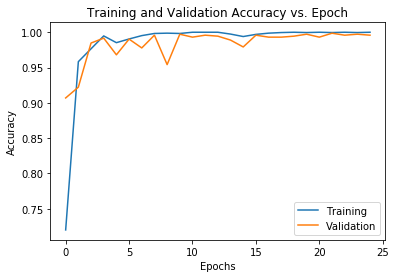

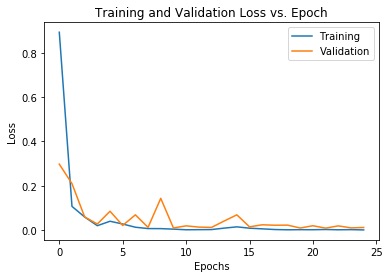

In [15]:

# PLOTTING
train_acc = np.zeros(args.epochs)
train_loss = np.zeros(args.epochs)

valid_acc = np.zeros(args.epochs)
valid_loss = np.zeros(args.epochs)

test_acc = np.zeros(args.epochs)
test_loss = np.zeros(args.epochs)

for i in range(0, len(train_results)):
  train_acc[i] = train_results[i][1]
  train_loss[i] = train_results[i][0]

  valid_acc[i] = valid_results[i][1]
  valid_loss[i] = valid_results[i][0]

  test_acc[i] = test_results[i][1]
  test_loss[i] = test_results[i][0]


plt.plot(train_acc, label='Training')
plt.plot(valid_acc, label='Validation')
plt.plot(test_acc, label = 'Test')
plt.title('Training, Validation, Test Accuracy vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# plt.ylim(0,1)
plt.legend()
plt.show()
#plt.savefig('accuracies',dpi=300)

# plt.plot(nRec, train_loss, label='Training')
# plt.plot(nRec, valid_loss, label='Validation')
plt.plot(train_loss, label='Training')
plt.plot(valid_loss, label='Validation')
plt.plot(test_loss, label='Test')
plt.title('Training, Validation, Test Loss vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.ylim(0,1)
plt.legend()
plt.show()

In [0]:
print(class_names)

['Air Canada Airbus A319', 'Air Canada Airbus A320', 'Air Canada Airbus A321', 'Air Canada Airbus A330-300', 'Air Canada Boeing 767-300', 'Air Canada Rouge Boeing 767-300', 'Air Transat Airbus A330-300', 'Airbus Beluga', 'American Boeing 777-300ER', 'Lufthansa Boeing 747-400', 'Porter Bombardier Q400', 'Westjet Boeing 737-800']


In [0]:
print(valid_acc)

[0.89166667 0.94583333 0.98333333 0.98194444 0.98888889 0.97361111
 0.99166667 0.98472222 0.99166667 0.99305556 0.99166667 0.99444444
 0.99583333 0.99722222 0.99444444 0.99444444 0.99583333 0.99166667
 0.99583333 0.99583333 0.99722222 0.99861111 0.99861111 0.99027778
 0.99722222]


predicted: American Boeing 777-300ER 		 actual: American Boeing 777-300ER
predicted: Airbus Beluga 		 actual: Airbus Beluga
predicted: Air Canada Boeing 767-300 		 actual: Air Canada Boeing 767-300
predicted: Westjet Boeing 737-800 		 actual: Westjet Boeing 737-800
predicted: Porter Bombardier Q400 		 actual: Porter Bombardier Q400
predicted: Air Canada Airbus A320 		 actual: Air Canada Airbus A320
predicted: Air Canada Airbus A319 		 actual: Air Canada Airbus A319
predicted: Westjet Boeing 737-800 		 actual: Westjet Boeing 737-800
predicted: Air Canada Rouge Boeing 767-300 		 actual: Air Canada Rouge Boeing 767-300
predicted: Porter Bombardier Q400 		 actual: Porter Bombardier Q400
predicted: Air Canada Boeing 767-300 		 actual: Air Canada Boeing 767-300
predicted: Air Canada Rouge Boeing 767-300 		 actual: Air Canada Rouge Boeing 767-300
predicted: American Boeing 777-300ER 		 actual: American Boeing 777-300ER
predicted: Air Canada Boeing 767-300 		 actual: Air Canada Boeing 767-300


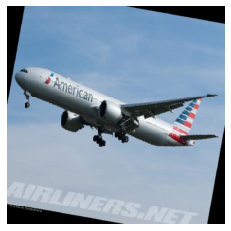

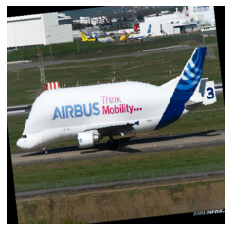

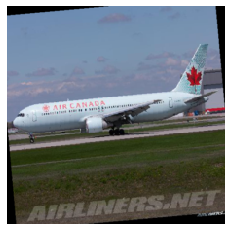

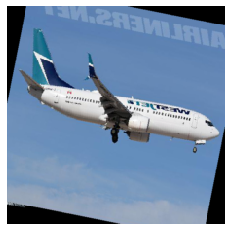

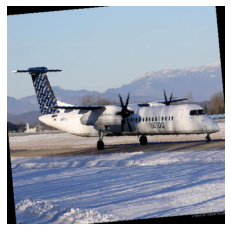

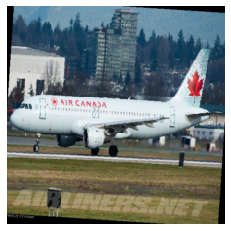

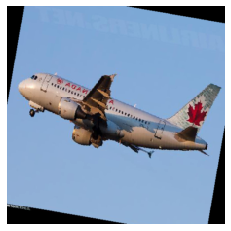

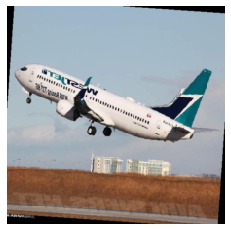

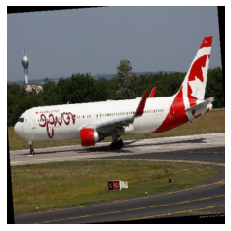

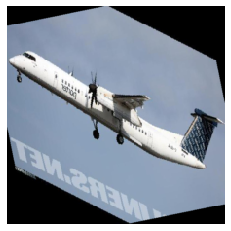

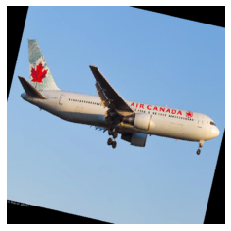

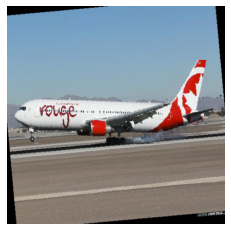

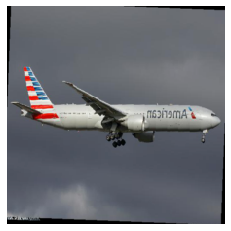

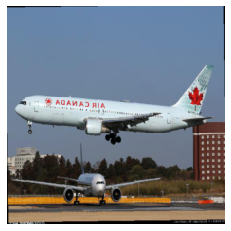

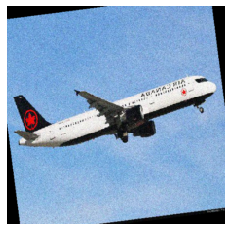

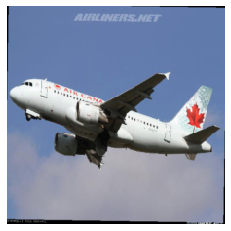

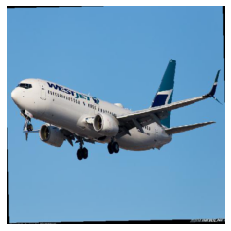

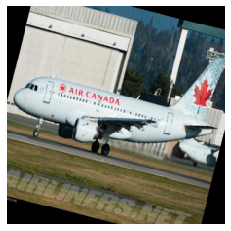

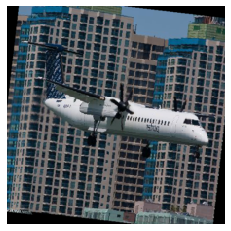

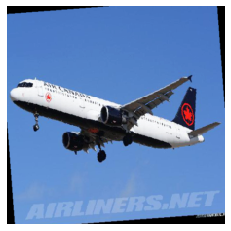

In [35]:
# Prediction visualization (TEST)
def visualize_model(model, class_names, dataloaderType, dataloaderName, num_images=20):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaderName[dataloaderType]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                #ax = plt.subplot(num_images//2, 2, images_so_far)
                #ax.axis('off')
                print('predicted: {} \t\t actual: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


model.load_state_dict(torch.load('/content/drive/My Drive/aer202_resnet_model_2.pt'))
model.to(device)

# Visualize predictions on small batch
dataloaderType = 'test'
dataloaderName = dataloaders
visualize_model(model, class_names, dataloaderType, dataloaderName)

In [129]:
# Test with new images 
TESTING_IMAGE_DIR = '/content/drive/My Drive/AER202/testing_dataset'

# Instantiate dataset from train_dir
dataset = datasets.ImageFolder(TESTING_IMAGE_DIR, transform = data_transforms['test'])


# Loading datasets into dataloader
dataloaders2 = {'test2': DataLoader(dataset, batch_size=batch_size, shuffle=False)}

print("Total Number of Images: ", len(dataset))



Total Number of Images:  12


predicted: Air Transat Airbus A330-300 		 actual: Air Canada Airbus A319
predicted: Air Canada Airbus A321 		 actual: Air Canada Airbus A319
predicted: Air Canada Airbus A320 		 actual: Air Canada Airbus A319
predicted: Lufthansa Boeing 747-400 		 actual: Air Canada Airbus A319
predicted: Westjet Boeing 737-800 		 actual: Air Canada Airbus A319
predicted: Airbus Beluga 		 actual: Air Canada Airbus A319
predicted: Air Canada Boeing 767-300 		 actual: Air Canada Airbus A319
predicted: Airbus Beluga 		 actual: Air Canada Airbus A319
predicted: Porter Bombardier Q400 		 actual: Air Canada Airbus A319
predicted: Westjet Boeing 737-800 		 actual: Air Canada Airbus A319
predicted: Air Canada Airbus A320 		 actual: Air Canada Airbus A319
predicted: Airbus Beluga 		 actual: Air Canada Airbus A319


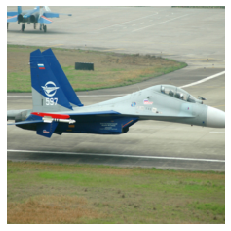

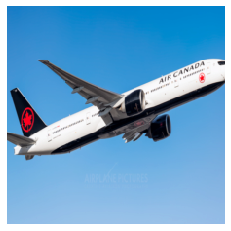

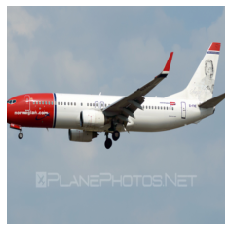

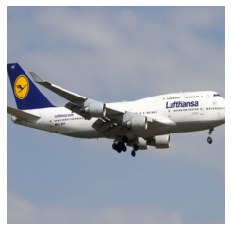

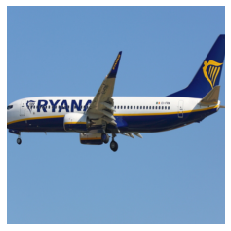

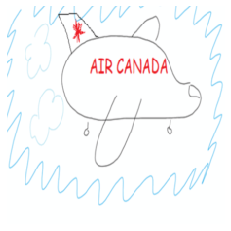

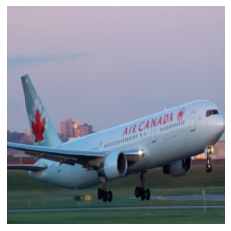

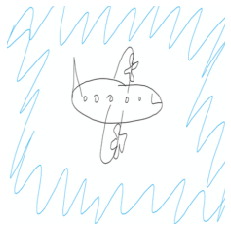

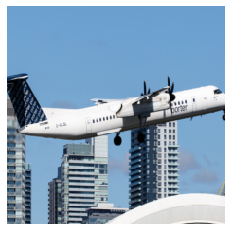

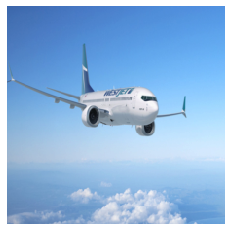

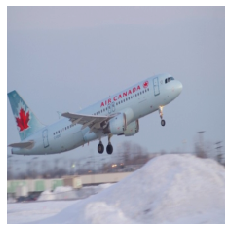

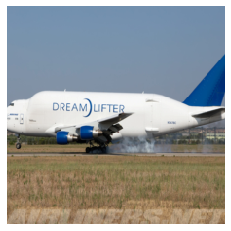

In [130]:

dataloaderType = 'test2'
dataloaderName = dataloaders2
num_images = len(dataset)
visualize_model(model, class_names, dataloaderType, dataloaderName, num_images)
